In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
def plot_FP_jitter_2D(m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,qvals,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,unstable_qlim = -6,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
        for jit in range(n_jit):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = 3)
            plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = 3)

In [121]:
def plot_FP_minimal(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = 'k',lesion_units = []):

    cmap=plt.get_cmap('rainbow')
        
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        if len(lesion_units)>0:
            model.lesion_units(sess, lesion_units)
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

#         for rule in rule_set:
#             trial = generate_trials(rule, hparams, mode='test',noise_on=False)
#             feed_dict = tools.gen_feed_dict(model, trial, hparams)
#             h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
#             T,S,N = np.shape(h_tf)
#             T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

#             for s in range(0,S,int(S/8)):

#                 if c_master == 'y_locs':
#                     c_inds = trial.y_loc[-1,:]
#                     c = cmap(c_inds[s]/(2*np.pi))
#                 elif c_master == 'x_locs':
#                     stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
#                     c = cmap(stim1_locs[s]/(2*np.pi))
#                 else:
#                     c = c_master

#                 X_trial = np.dot(h_tf[T_inds,s,:],D_use)
#                 plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T_inds = get_T_inds(trial,fp_epoch)

        if c_master == 'y_locs':
            c_inds = trial.y_loc[-1,:]
            c = cmap(c_inds[t_num]/(2*np.pi))
        elif c_master == 'x_locs':
            stim1_locs = np.min(trial.stim_locs,axis=1)
            c = cmap(stim1_locs[t_num]/(2*np.pi))
        else:
            c = c_master

#         X_trial = np.dot(h_tf[T_inds,t_num,:],D_use)
#         plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = .8, linewidth = 5)
#         plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = .8, linewidth = 5)
#         plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = .8, linewidth = 5, markersize = 10)

        for fp_ind in fp_inds:

            if np.max(eig_decomps[fp_ind]['evals'])>.9999:
                markerfacecolor = 'None'

            else:
                markerfacecolor = c

#             x_t = np.matlib.repmat(trial.x[T_inds[0],t_num,:],n_steps,1)
#             for jit in range(n_jit):
#                 h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
#                 h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
#                 jitter = np.dot(h_t,D_use)
#                 plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .1)
#                 plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = .1)

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            # print(np.shape(fp))
            plt.plot(fp[0],fp[1],'o',c = c,linewidth = 5,markersize = 6,markerfacecolor = markerfacecolor)

#             h_t = vanilla_run_with_h0(params, x_t, h_tf[T_inds[0],t_num,:], hparams)
#             jitter = np.dot(h_t,D_use)
#             plt.plot(jitter[-1,0],jitter[-1,1],'^k',c = c)
#             plt.plot(jitter[:,0],jitter[:,1],'-k',c = c,linewidth = 1)
#             plt.plot(jitter[0,0],jitter[0,1],'xk',c = c,linewidth = 5,markersize = 10)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(rule_master)

In [3]:
model_n = 0
task_list = ['delaygo','dmsgo']#hp['rule_trains']
rule = task_list[0]
which_net = 'l2w0001'
fldr = 'all_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','interpolate_motifs')
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


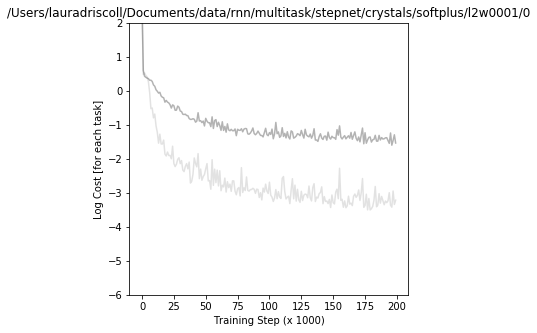

In [4]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [5]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [6]:
########## X STIM ###########

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [0,36]
trial_num = [int(10*t/36) for t in t_set]
n_interp = 20
n_fps_init = 60
n_fps = 60
trial_set = range(0,80,10)
rule_set = [task_list[2],]
epoch_set = ['stim1',]
step_file = 'interp_stim'
axs = 'tdr'
linestyle = ['-','--']

ei = 0
epoch = epoch_set[ei]
ri = 0
rule = rule_set[ei]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)

stim_axs = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[stim_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')
epoch_name, rule_name, _, _ = take_names(epoch,rule)
axes_label1 =  epoch_name +' '+ axs + ' 1'
axes_label2 = epoch_name +' '+ axs + ' 2'

# use_yinds = [2,4]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['navy','gold']

_,x = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch_set[0])
x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
       linestyle = linestyle[ri], alpha = .1)
    
for si in range(len(t_set)):
    ax = plt.subplot(111)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[si])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_discrete[si],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    plt.plot(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],'o',c = cmap_discrete[si],
             markersize = 10, alpha = 1,linewidth = 5)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

#     X_trial = np.dot(x_epoch[trial_set[si],:,:],D_use)
#     plt.plot(X_trial[:,0],X_trial[:,1],c = cmap_discrete[si],linewidth = 2, 
#            linestyle = linestyle[ri], alpha = 1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[si],epoch,sorted_fps,range(len(sorted_fps)),qvals,
                      rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
                      n_jit = 1,unstable_qlim = -10,c = cmap_discrete[si])

    for step_i in range(n_interp):
        
        f = rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,rule,f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = rule_name+ ' X STIM'
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,step_file,figname),dpi = 30)
figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_'+tit+'.png'
plt.savefig(os.path.join(figpath,step_file,figname),dpi = 30)
plt.show()

IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [ ]:
from tools_lnd import make_Beta
fp_epoch = 'delay1'
Beta_qr,Y_labels = make_Beta(m,task_list,fp_epoch)
Beta_inds = [4,5]
D_use = Beta_qr[:,Beta_inds]
axes_label1 =  Y_labels[Beta_inds[0]]
axes_label2 = Y_labels[Beta_inds[1]]

In [ ]:
from tools_lnd import make_h_all
rule = 'delaygo'
e_name = 'delay1'
trial = generate_trials(rule, hparams, 'test', noise_on=False)
h_all_byepoch, h_all_byrule = make_h_all(m)
X_rule = h_all_byrule[rule]

X_use = X_rule

from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
fp_pca = pca.fit_transform(np.reshape(X_use[:],(-1,hp['n_rnn'])))
D_use = pca.components_.T

In [11]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [12]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    hparams = model.hp
    alpha = hparams['dt']/hparams['tau']
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]

    trial = generate_trials(rule, hparams, mode='test',noise_on=False)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [26]:
def plot_FP_jitter(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = 'k',lesion_units = []):

    cmap=plt.get_cmap('rainbow')
        
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        if len(lesion_units)>0:
            model.lesion_units(sess, lesion_units)
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        for rule in rule_set:
            trial = generate_trials(rule, hparams, mode='test',noise_on=False)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            T,S,N = np.shape(h_tf)
            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

#             for s in range(0,S,int(S/8)):

#                 if c_master == 'y_locs':
#                     c_inds = trial.y_loc[-1,:]
#                     c = cmap(c_inds[s]/(2*np.pi))
#                 elif c_master == 'x_locs':
#                     stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
#                     c = cmap(stim1_locs[s]/(2*np.pi))
#                 else:
#                     c = c_master

#                 X_trial = np.dot(h_tf[T_inds,s,:],D_use)
#                 plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T_inds = get_T_inds(trial,fp_epoch)

        if c_master == 'y_locs':
            c_inds = trial.y_loc[-1,:]
            c = cmap(c_inds[t_num]/(2*np.pi))
        elif c_master == 'x_locs':
            stim1_locs = np.min(trial.stim_locs,axis=1)
            c = cmap(stim1_locs[t_num]/(2*np.pi))
        else:
            c = c_master

        X_trial = np.dot(h_tf[T_inds,t_num,:],D_use)
        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = .8, linewidth = 5)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = .8, linewidth = 5)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = .8, linewidth = 5, markersize = 10)

        for fp_ind in fp_inds:

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                markerfacecolor = 'None'

            else:
                markerfacecolor = c

            x_t = np.matlib.repmat(trial.x[T_inds[0],t_num,:],n_steps,1)
            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = .1)

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            # print(np.shape(fp))
            plt.plot(fp[0],fp[1],'o',c = c,linewidth = 5,markersize = 3,markerfacecolor = markerfacecolor)

            h_t = vanilla_run_with_h0(params, x_t, h_tf[T_inds[0],t_num,:], hparams)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^k',c = c)
            plt.plot(jitter[:,0],jitter[:,1],'-k',c = c,linewidth = 1)
            plt.plot(jitter[0,0],jitter[0,1],'xk',c = c,linewidth = 5,markersize = 10)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(rule_master)

In [49]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)

In [ ]:
filename,_ = get_filename(trial,epoch,trial_num[ri])
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
fp_struct = np.load(f)

In [72]:
q_str = 'tol_q_e_3.0'

In [74]:
f = '_'.join(rule_set)+'_'+'_'.join(epoch_set)+'_x'+str(round(t_set[0],2))+'_x'+str(round(t_set[1],2))
filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],q_str,f+'_step_'+str(step_i)+'.npz')
fp_struct = np.load(filename)
step_fps = fp_struct['xstar']

(array([247.,  38.,  14.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([1.24394750e-15, 1.96459412e-05, 3.92918824e-05, 5.89378236e-05,
        7.85837648e-05, 9.82297061e-05, 1.17875647e-04, 1.37521588e-04,
        1.57167530e-04, 1.76813471e-04, 1.96459412e-04]),
 <a list of 10 Patch objects>)

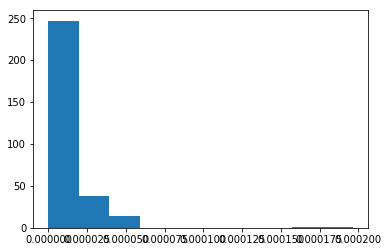

In [77]:
plt.hist(fp_struct['qstar'][fp_struct['qstar']<.001])

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
delay1
delay1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/dat

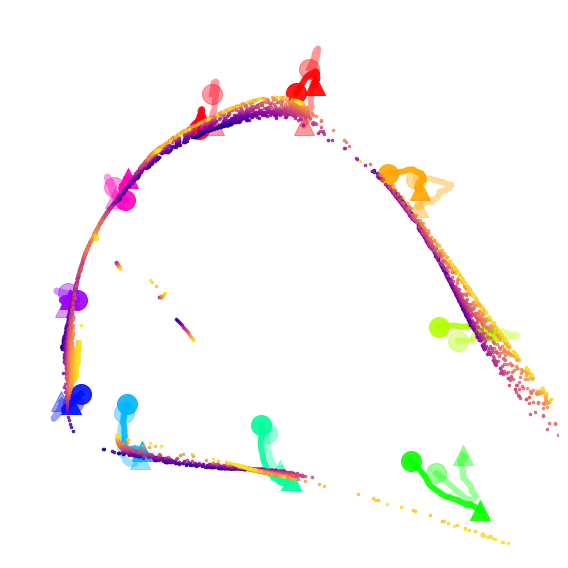

In [126]:
########## X TASK ###########

fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['dmsgo','delaygo']
epoch_set = ['delay1','delay1']
step_file = 'interp_tasks'
linestyle = ['-','-']
axs = 'pca_fp'
q_str = 'tol_q_e_3.0'

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

# rule_axs = 0
# use_yinds = [4,5]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]
# D_use = Beta_qr[:,use_yinds]

# f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
# D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')

# D_use[:,1] = w_out[:,2]
# axes_label2 = 'out sin'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['navy','gold']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use,_,_ = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rand_step_coef = 0
al = .3

# color_list = ['purple','gold','teal']

for ri in range(2):
    
    rule = rule_set[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    ax = plt.subplot(111)
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
           linestyle = linestyle[ri], alpha = (ri/2)+.4, markersize = 20)
    
#     filename,_ = get_filename(trial,epoch,trial_num[ri])
#     f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
#     fp_struct = np.load(f)
#     fp_inds = fp_struct['qstar']<.001
#     sorted_fps = fp_struct['xstar'][fp_inds,:]
#     J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
#     eig_decomps = comp_eig_decomp(J_xstar)
#     fp_inds = range(len(eig_decomps))
    
#     plot_FP_jitter(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
#                rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
#                    n_jit = 0,c_master = c_master)

    for step_i in range(n_interp):
        
        f = '_'.join(rule_set)+'_'+'_'.join(epoch_set)+'_x'+str(round(t_set[0],2))+'_x'+str(round(t_set[1],2))
        filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],q_str,f+'_step_'+str(step_i)+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']
        fp_inds = fp_struct['qstar']<.0001

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[fp_inds,0],fp_project[fp_inds,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp),alpha = .5)


tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
# plt.title(tit,fontsize = 18)
# plt.xlabel(axes_label1,fontsize = 18)
# plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.xlim((-5,13))
plt.ylim((-8,10))

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
    
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [98]:
len(T_inds)

60

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

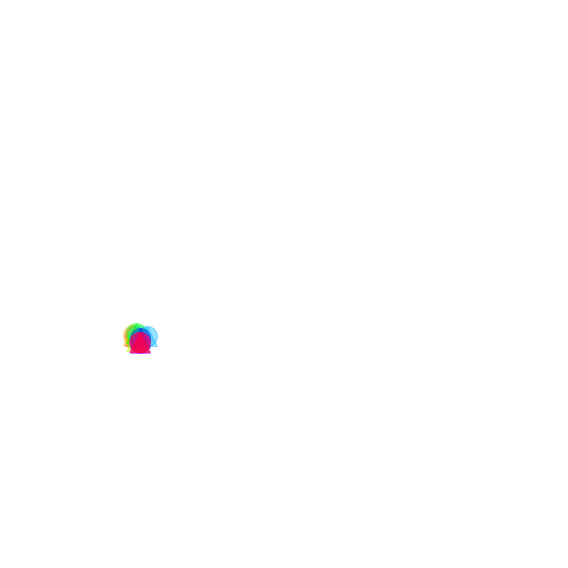

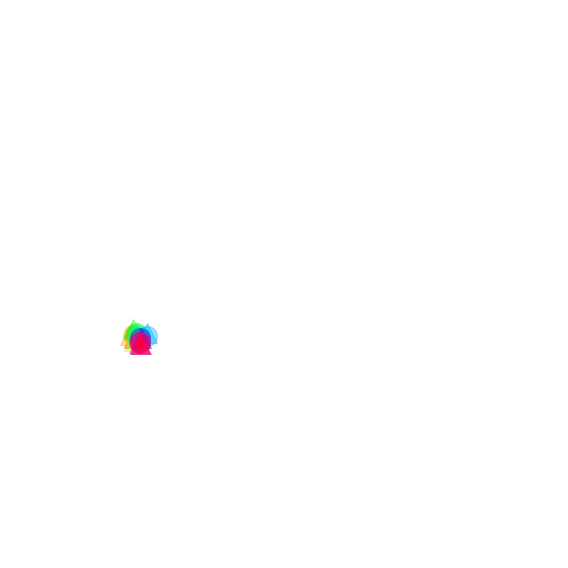

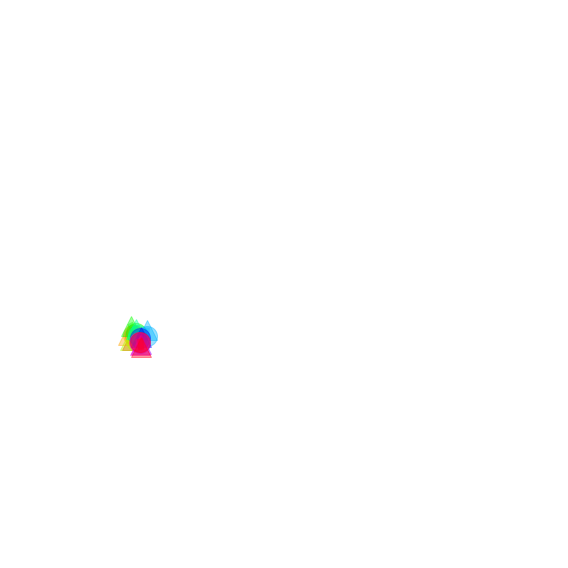

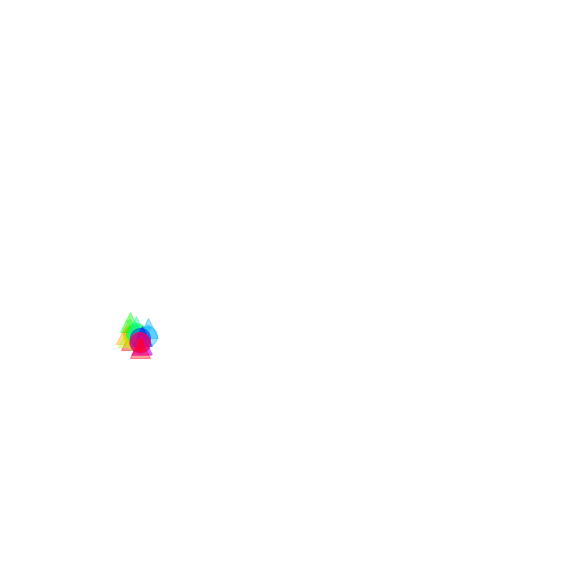

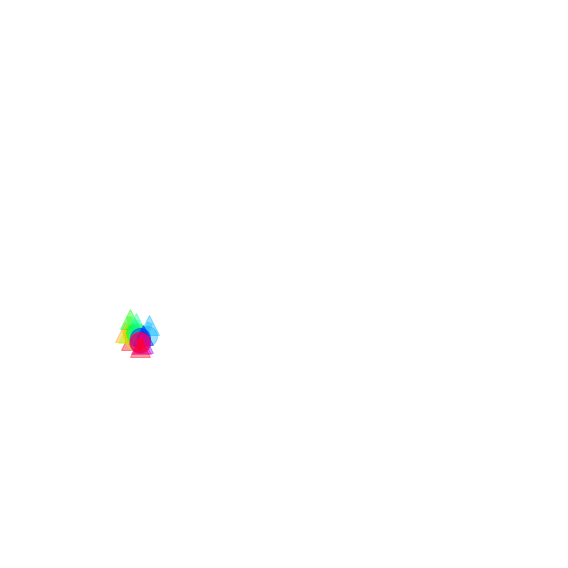

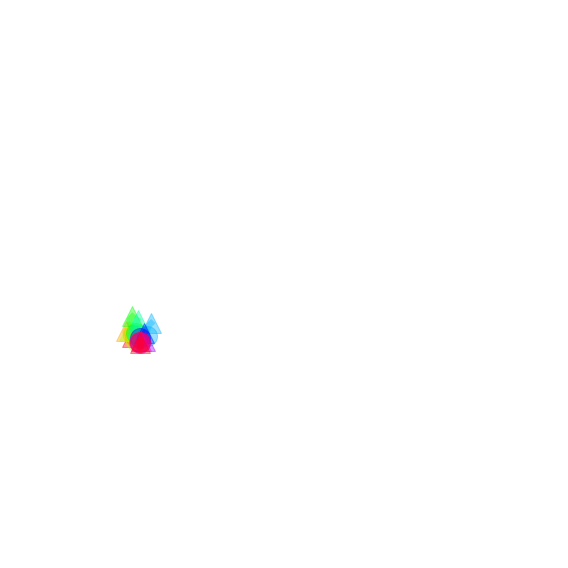

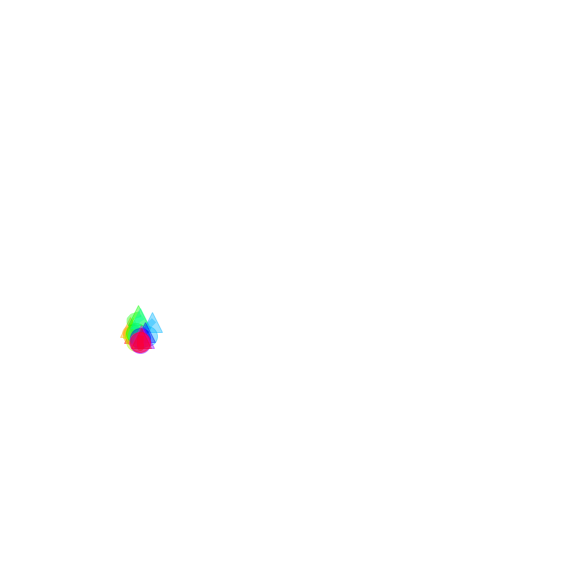

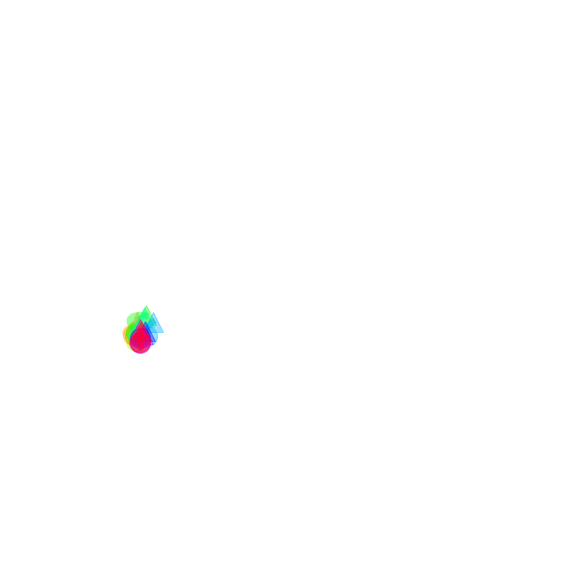

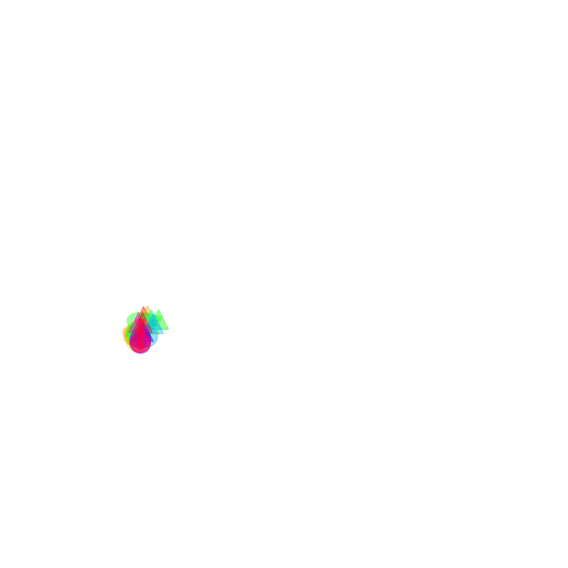

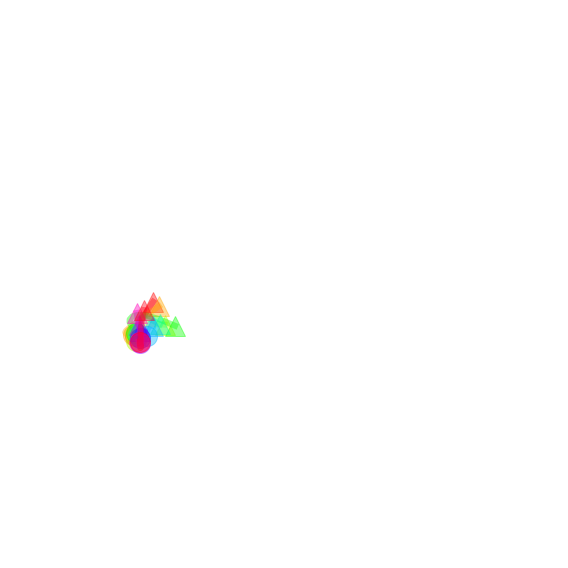

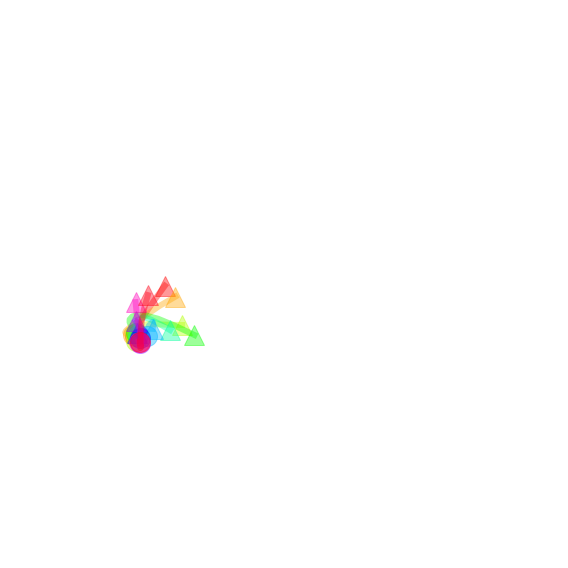

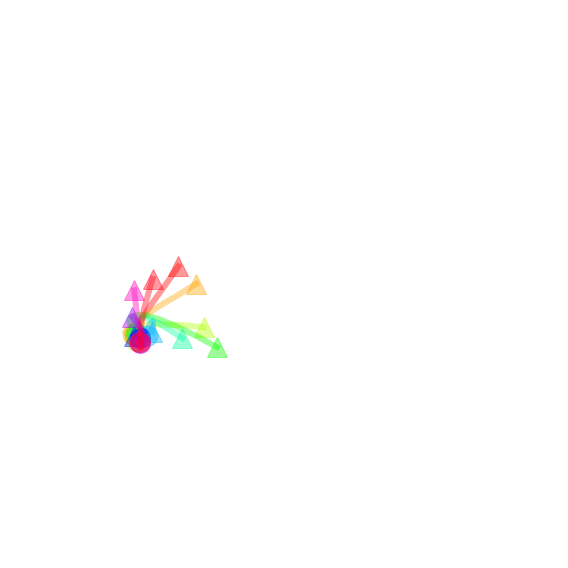

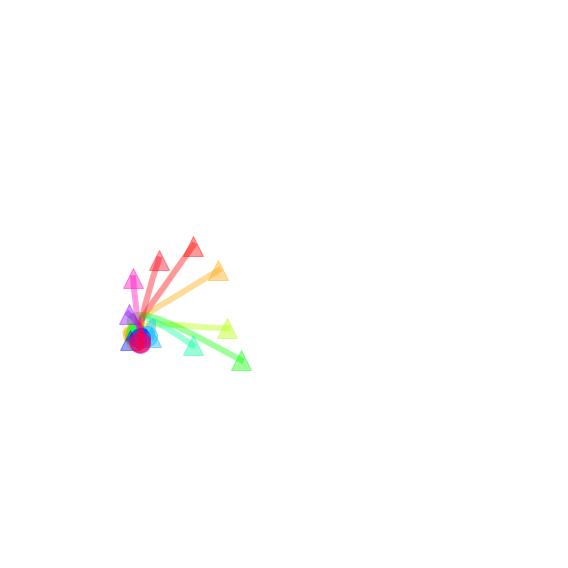

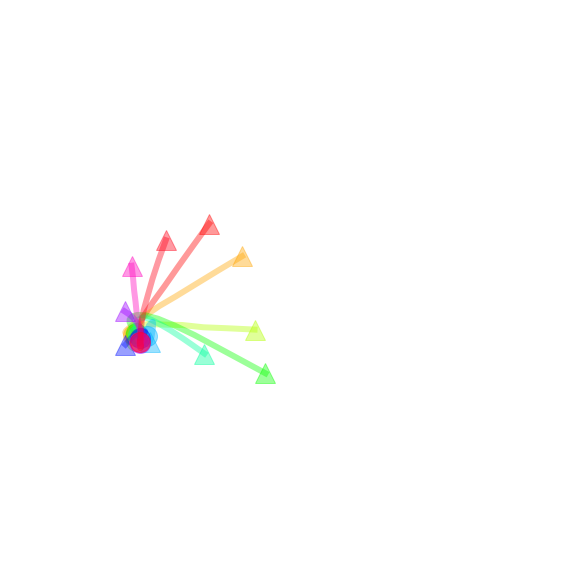

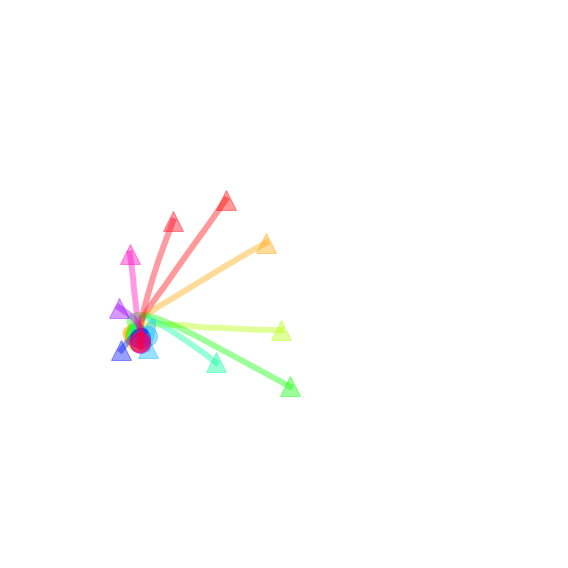

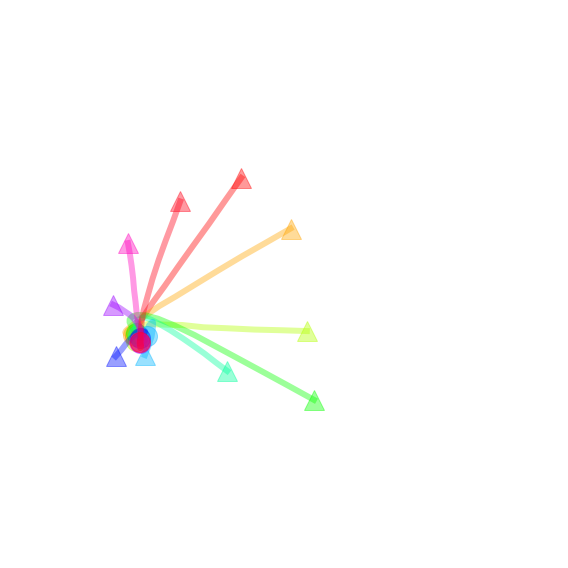

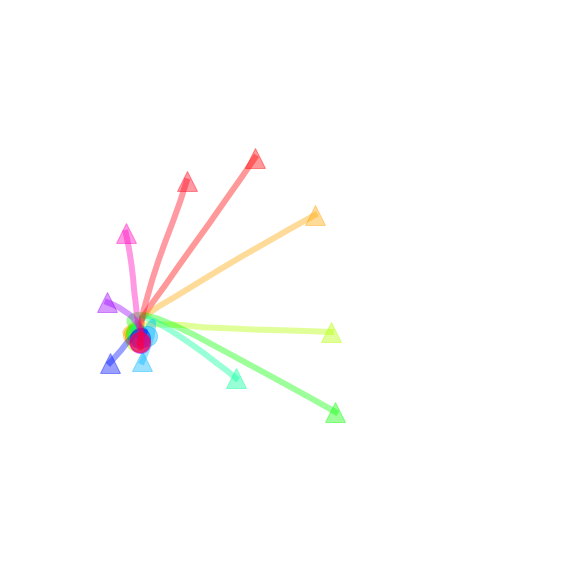

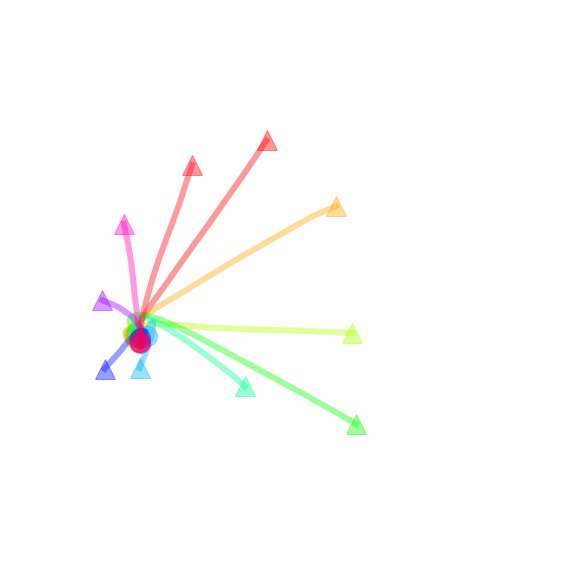

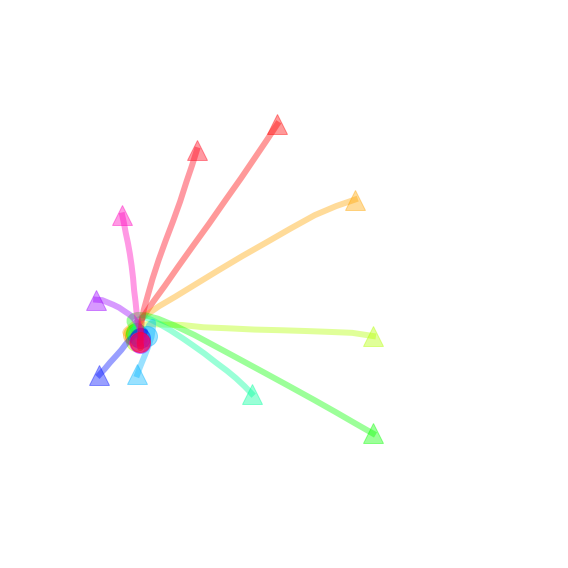

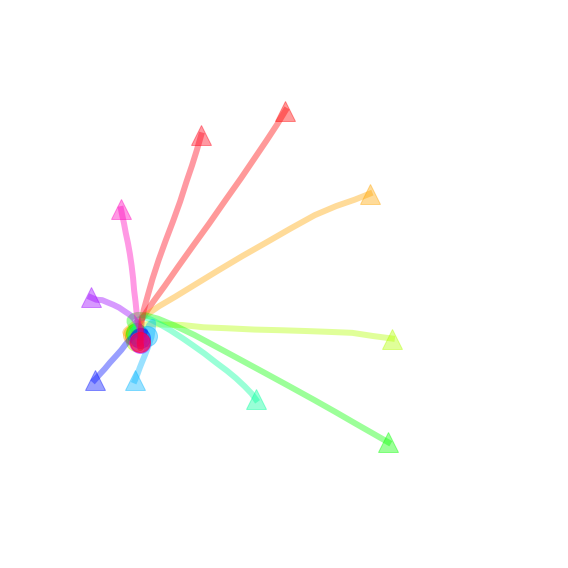

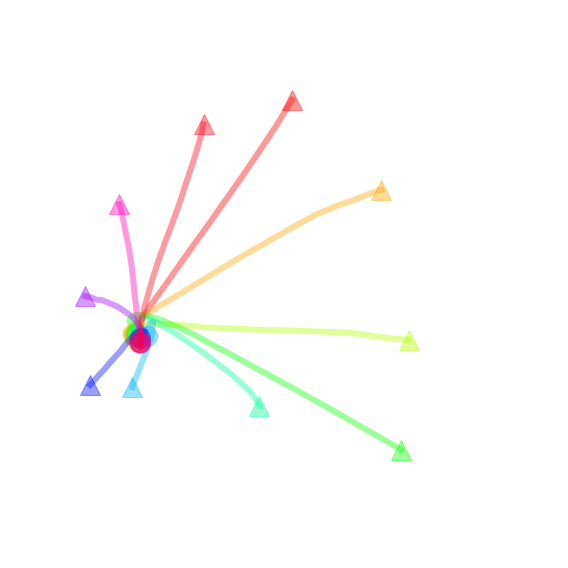

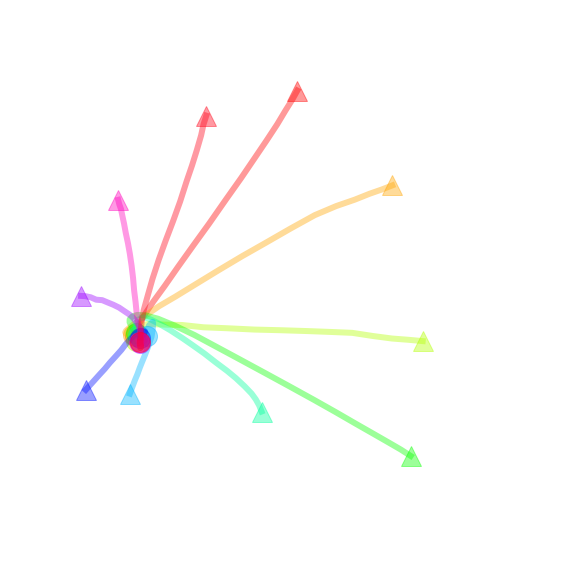

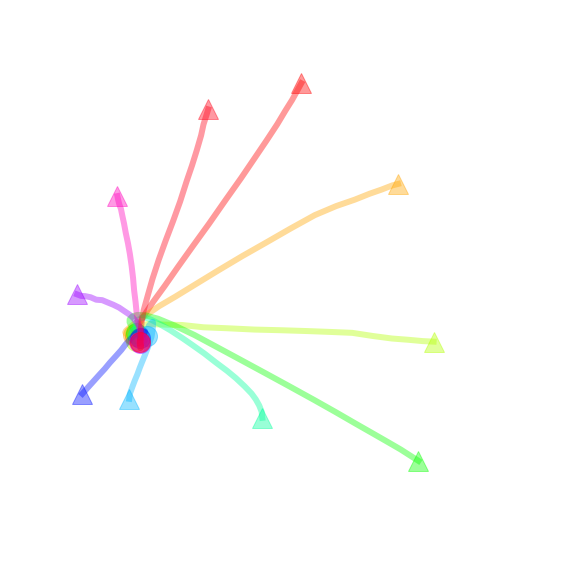

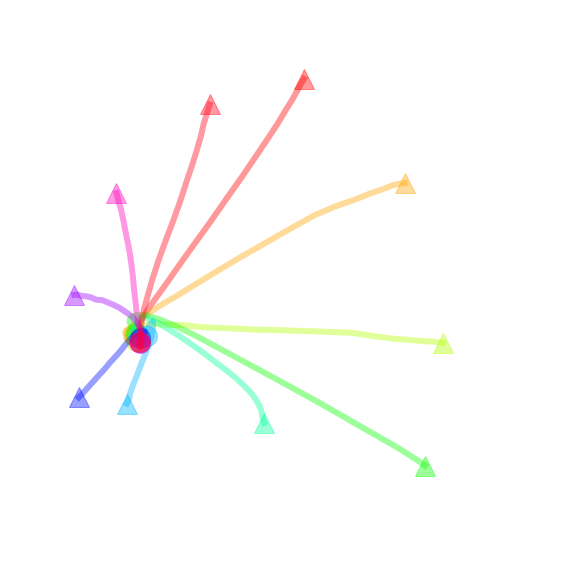

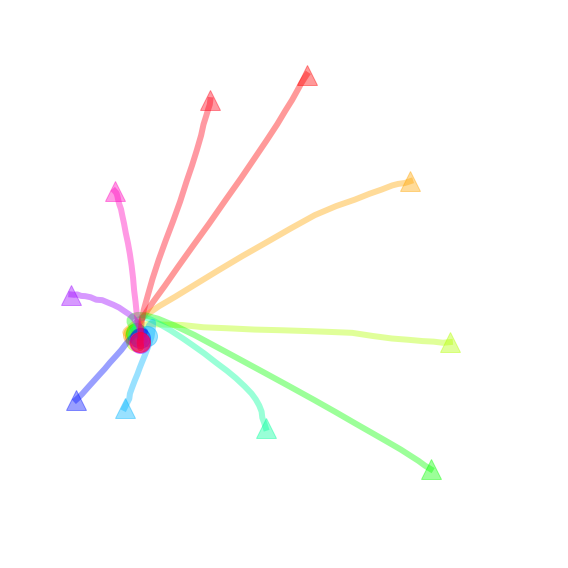

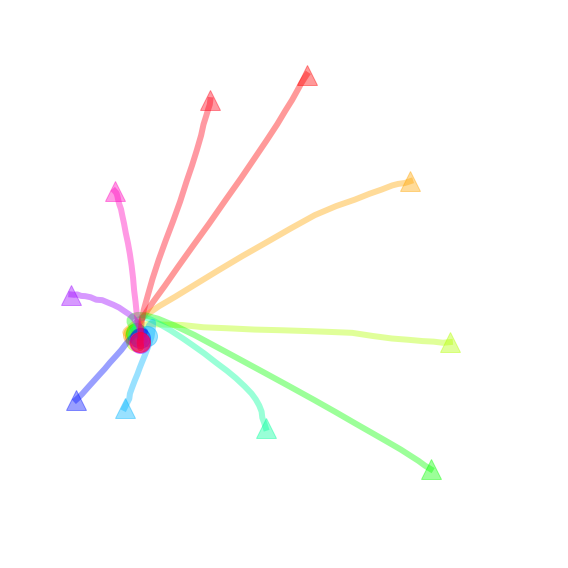

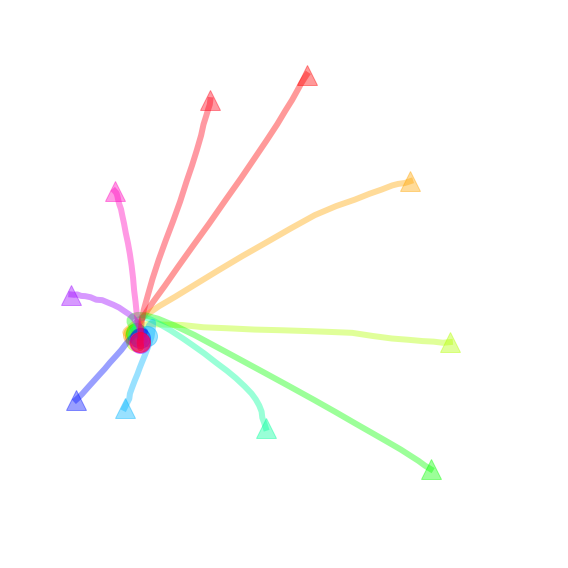

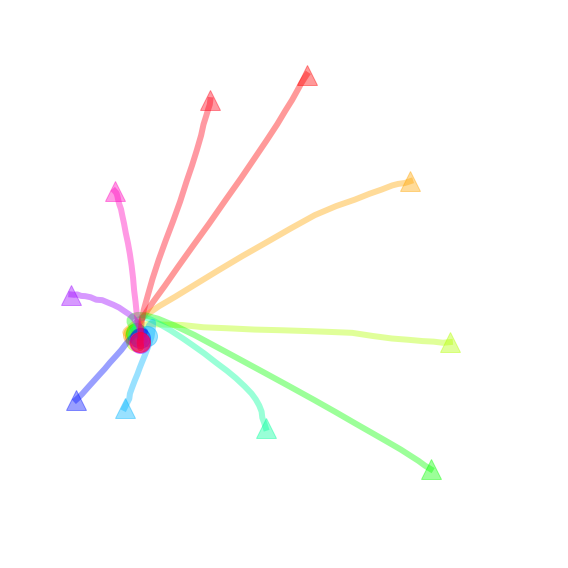

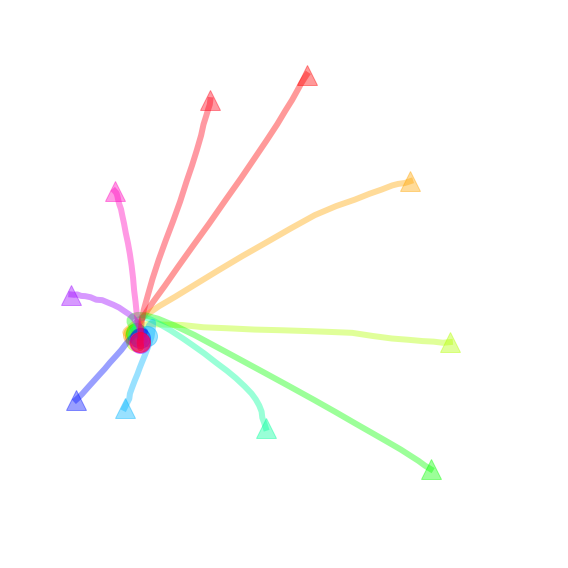

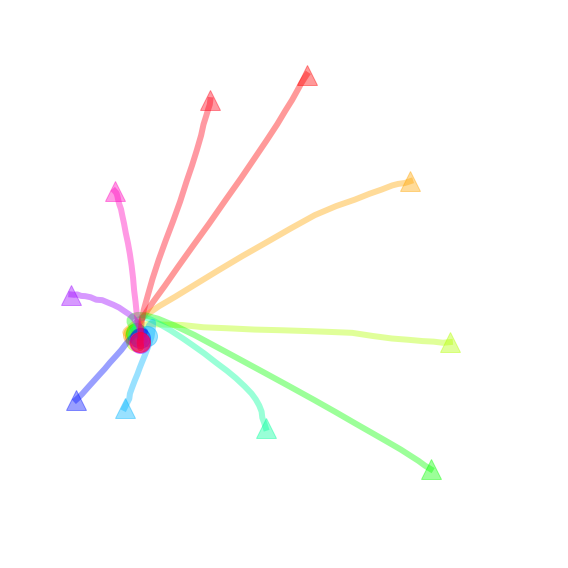

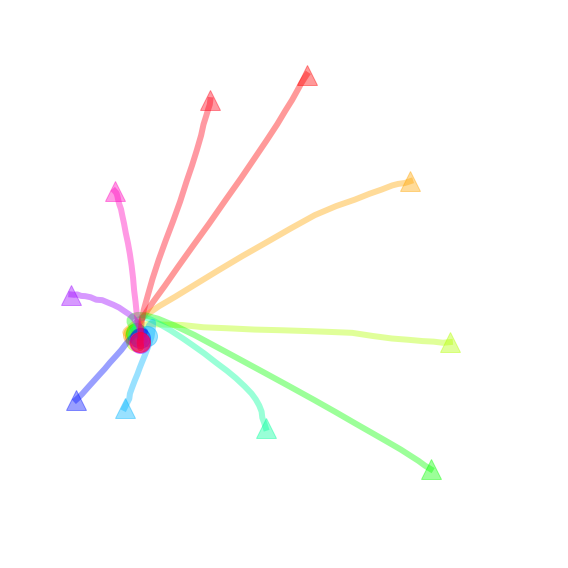

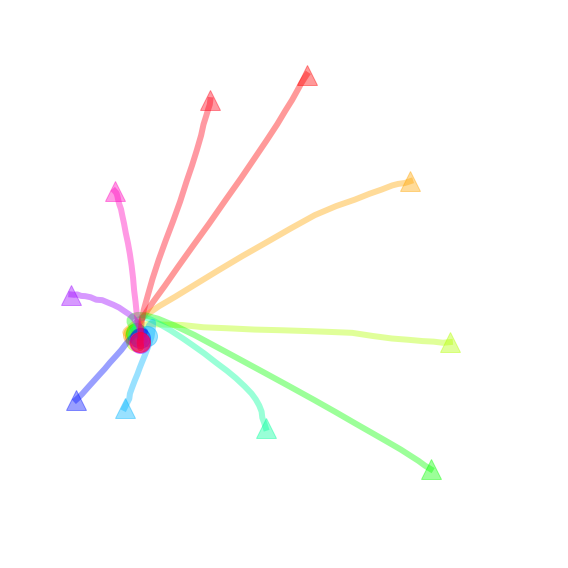

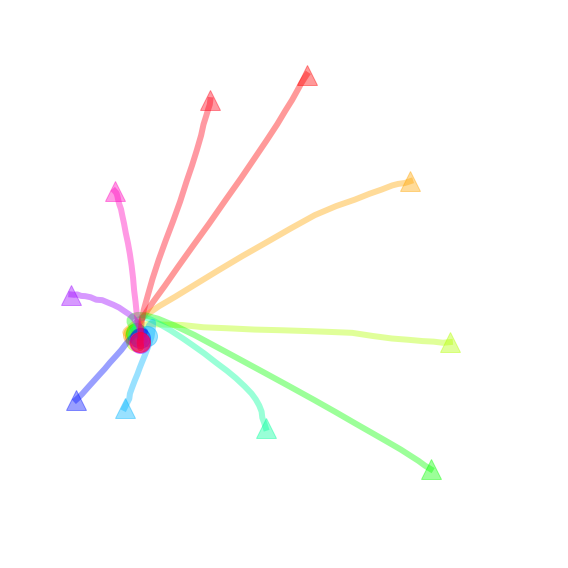

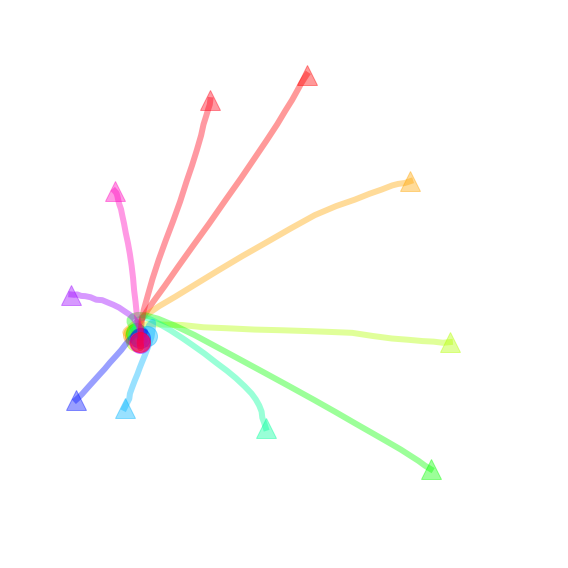

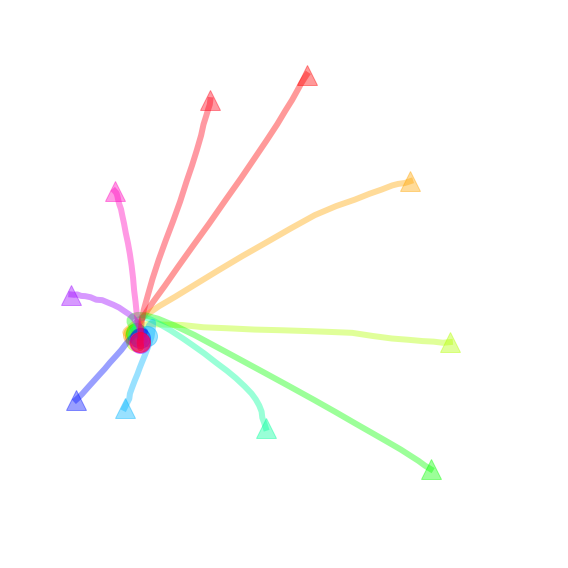

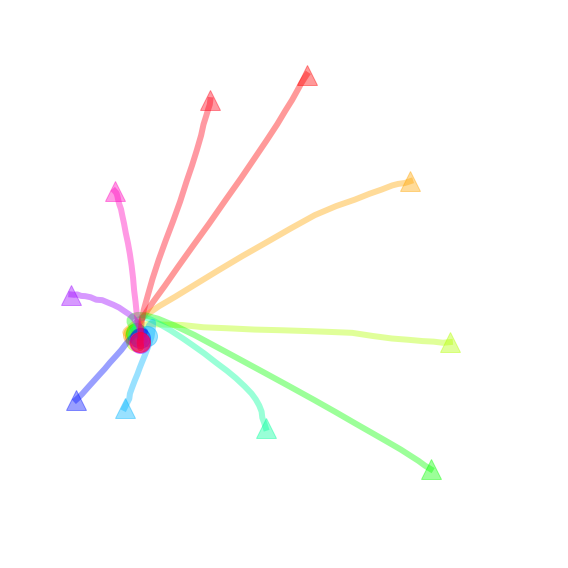

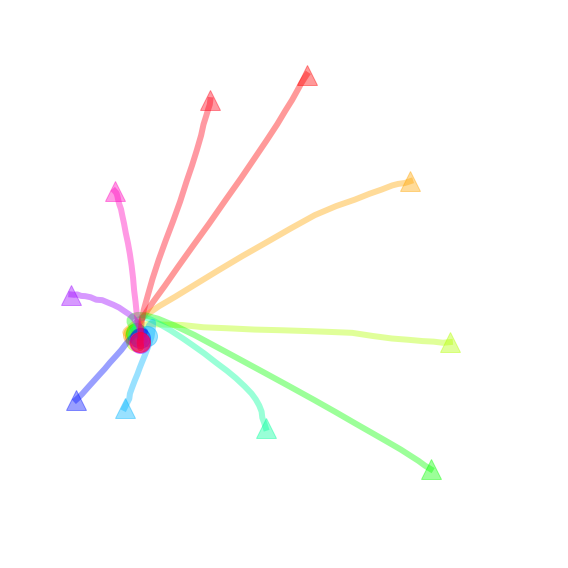

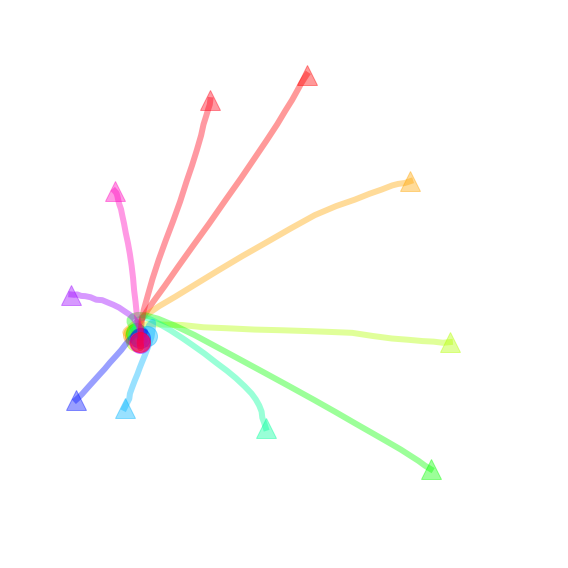

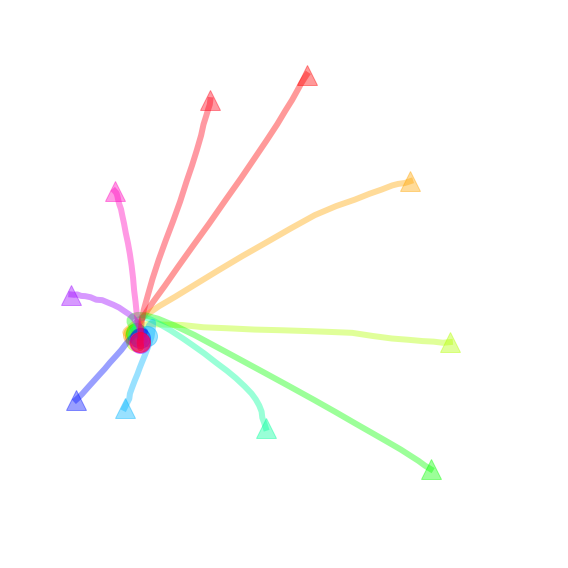

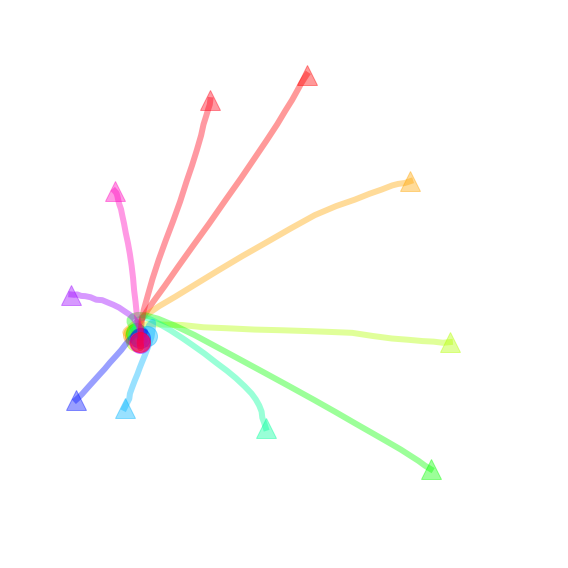

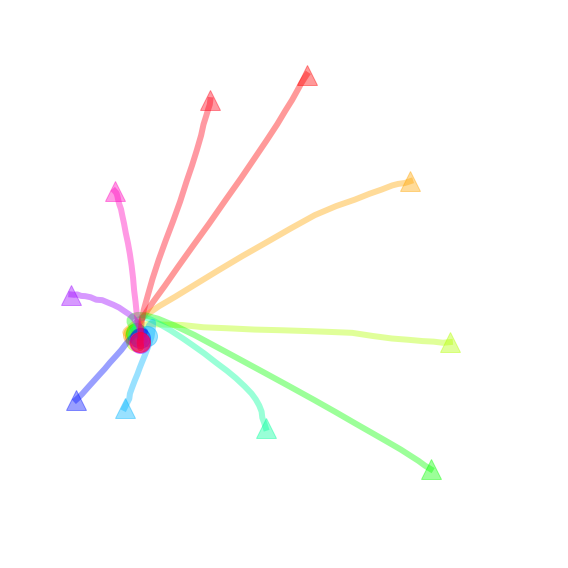

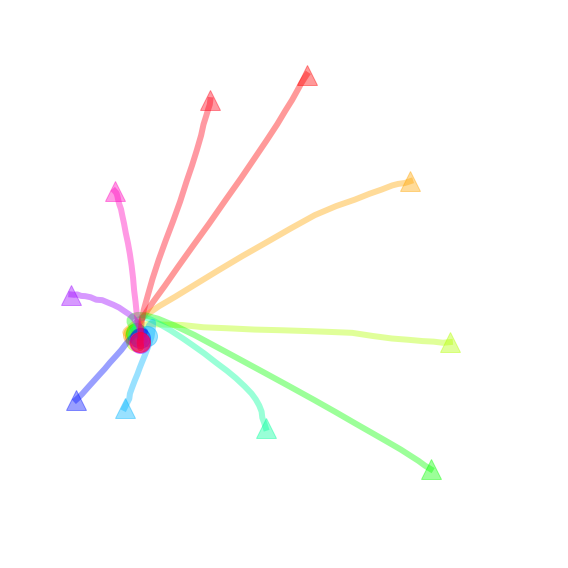

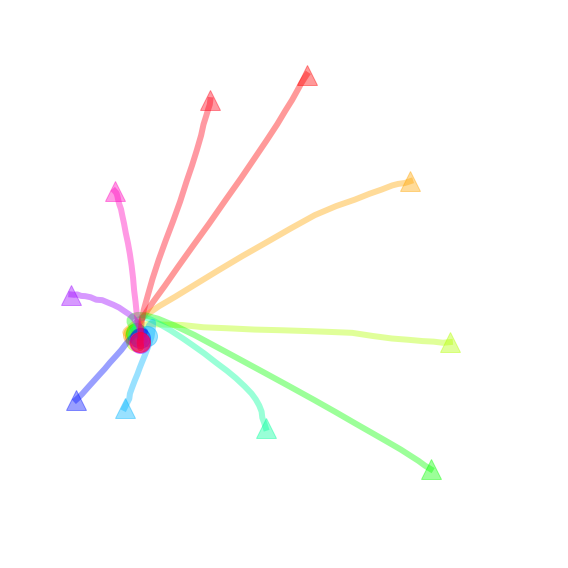

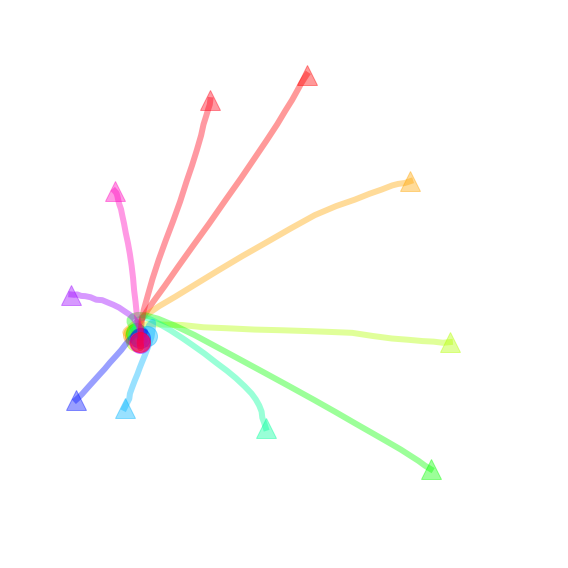

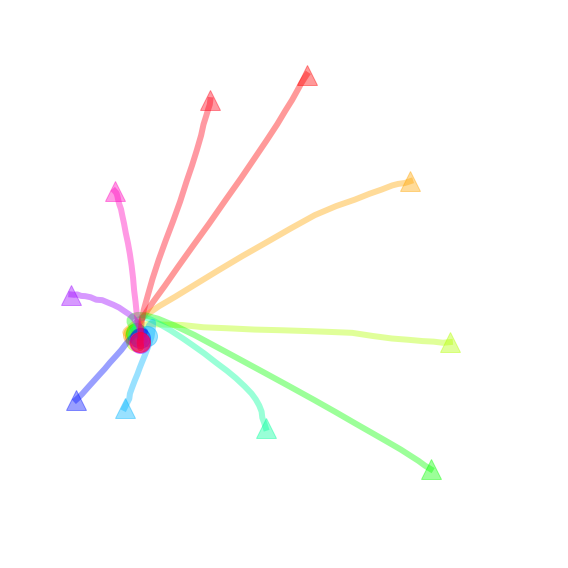

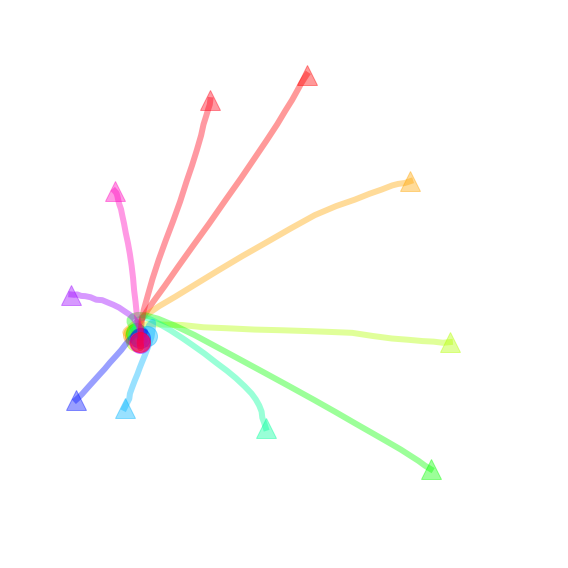

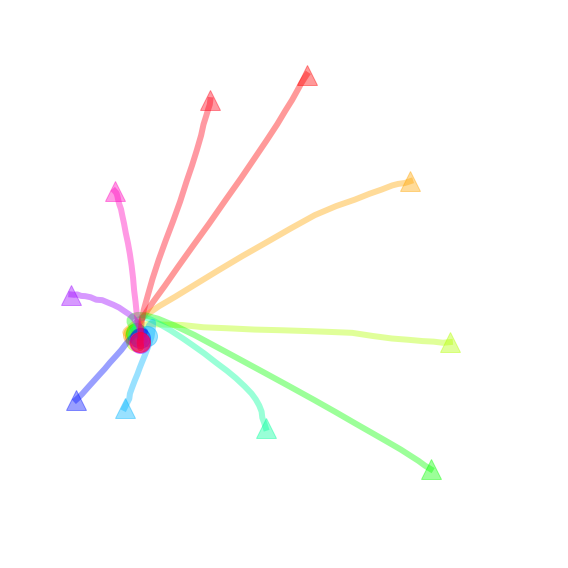

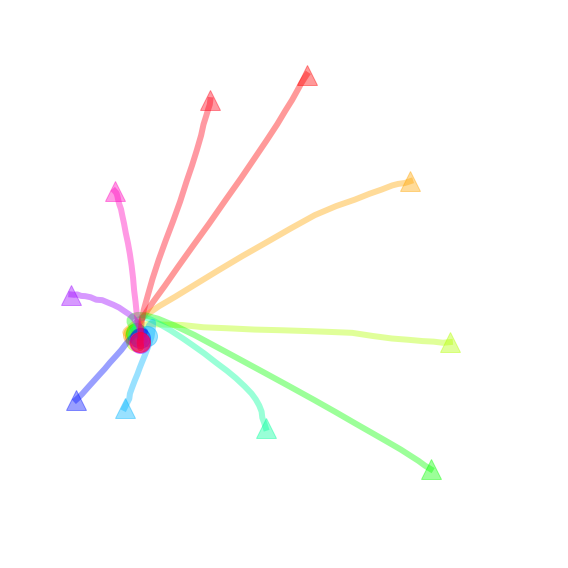

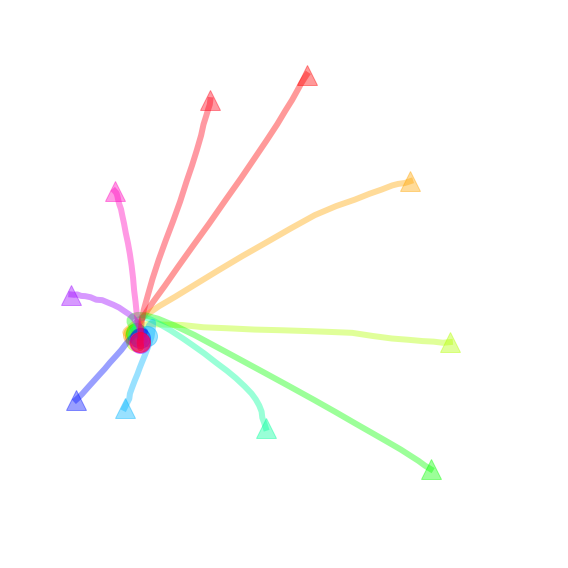

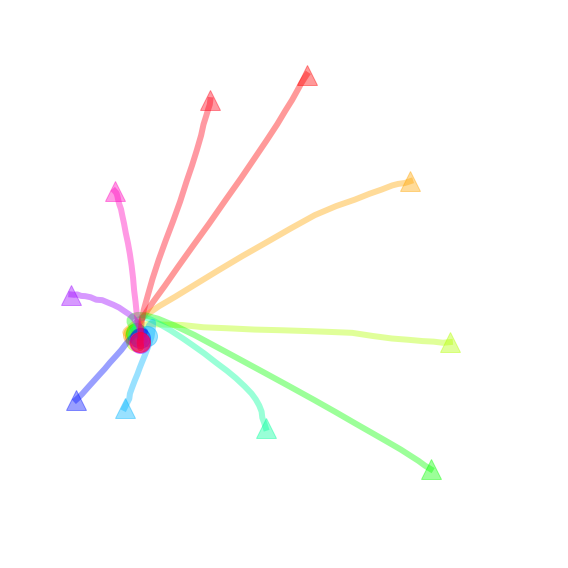

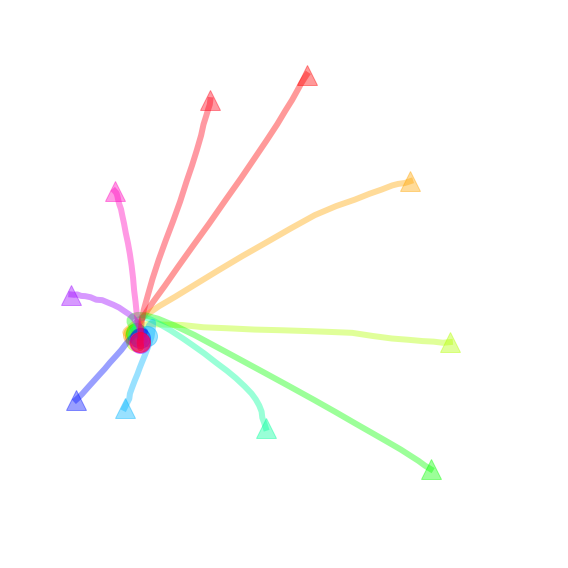

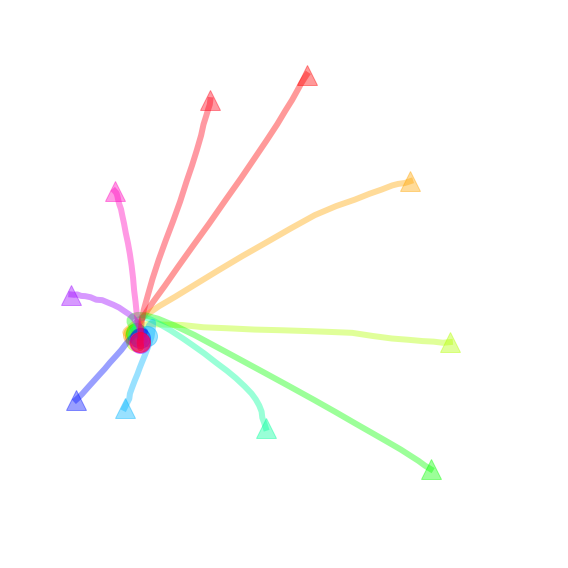

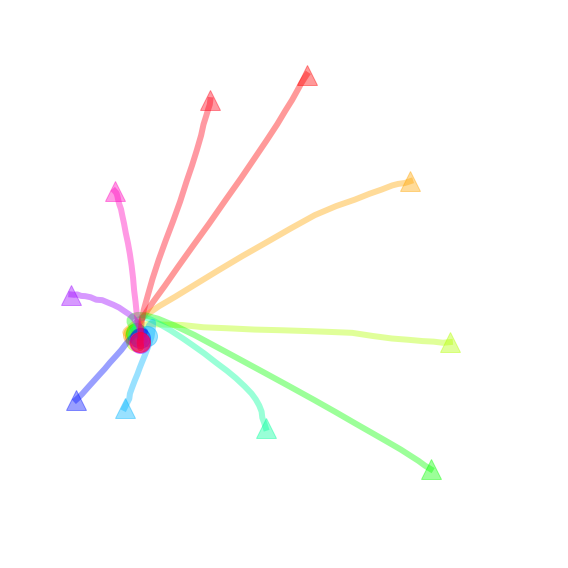

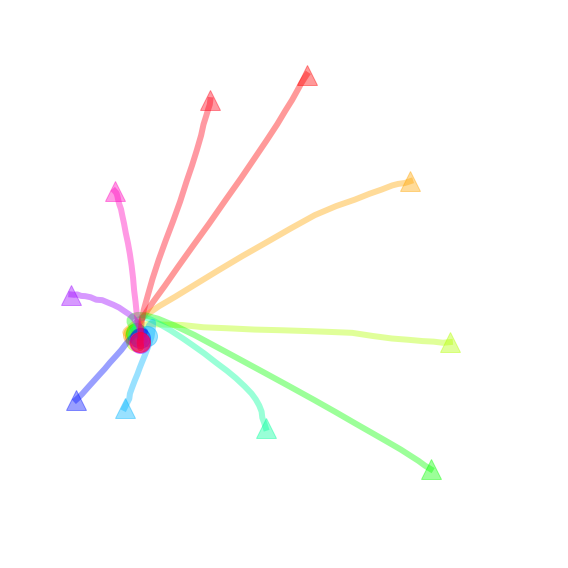

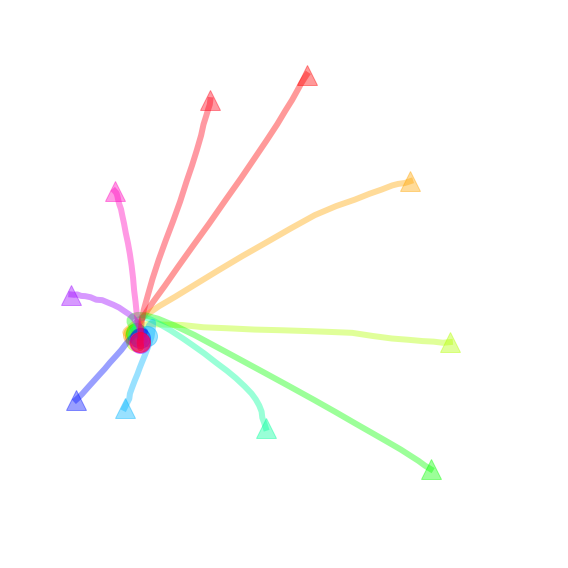

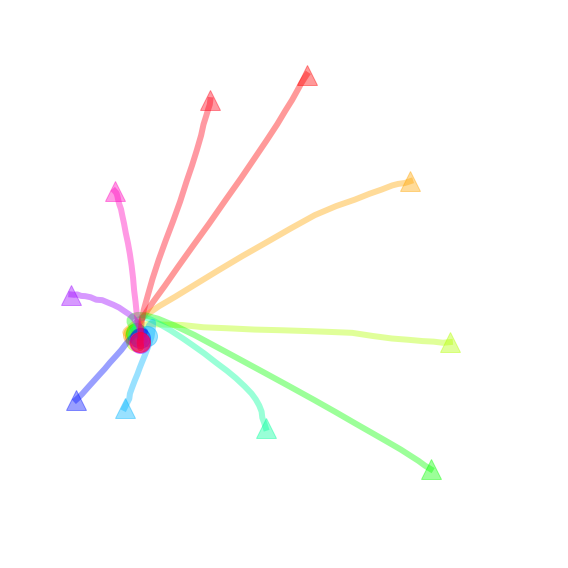

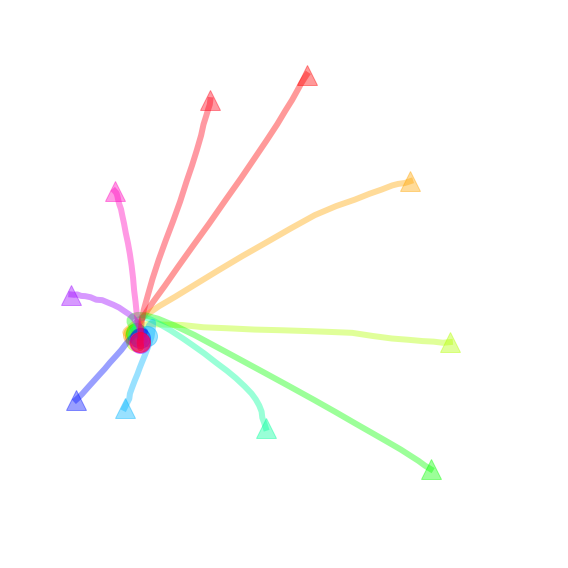

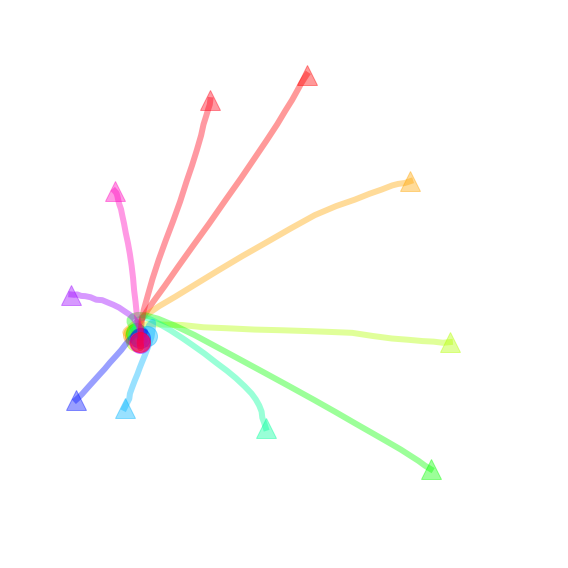

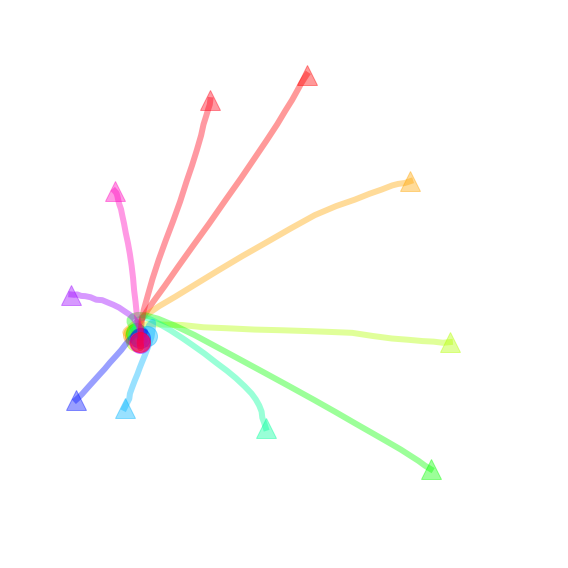

In [129]:
########## X TASK ###########
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['dmsgo','delaygo']
epoch_set = ['stim1','stim1']
step_file = 'interp_tasks'
linestyle = ['-','-']
axs = 'pca_fp'
q_str = 'tol_q_e_3.0'

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['thistle','brown']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

# trial = gen_trials_from_model_dir(m,rule,noise_on = False)
# filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
# f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
# D_use,_,_ = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
# epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
# epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
# axes_label1 = axs+' 1'
# axes_label2 = axs+' 2'
# axes_label3 = axs+' 3'

rand_step_coef = 0
al = .3

ri_range = 1
movie_inds = 60
w_fp = 0

for im_num in range(1,movie_inds):
    fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
    ax = plt.subplot(111)
    
    for ri in range(ri_range):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds[:im_num]],(1,2,0))

        ax = plt.subplot(111)
        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
               linestyle = linestyle[ri], alpha = (ri/2)+.4, markersize = 20)

        if w_fp:
            
#             if im_num==1:
            filename,_ = get_filename(trial,epoch,trial_num[ri])
            f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
            fp_struct = np.load(f)
            fp_inds = fp_struct['qstar']<.001
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            eig_decomps = comp_eig_decomp(J_xstar)
            fp_inds = range(len(eig_decomps))

            plot_FP_minimal(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
                       rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
                           n_jit = 0,c_master = c_master)

    #     for step_i in range(n_interp):

    #         f = '_'.join(rule_set)+'_'+'_'.join(epoch_set)+'_x'+str(round(t_set[0],2))+'_x'+str(round(t_set[1],2))
    #         filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],q_str,f+'_step_'+str(step_i)+'.npz')
    #         fp_struct = np.load(filename)
    #         step_fps = fp_struct['xstar']
    #         fp_inds = fp_struct['qstar']<.0001

    #         fp_project = np.dot(step_fps,D_use)
    #         plt.plot(fp_project[fp_inds,0],fp_project[fp_inds,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp),alpha = .5)


    tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    plt.xlim((-5,13))
    plt.ylim((-8,10))
    
    if w_fp:
        movie_dir = os.path.join(figpath,step_file,epoch,'movie_dir_ri_range_'+str(ri_range)+'_wfp')
    else:
        movie_dir = os.path.join(figpath,step_file,epoch,'movie_dir_ri_range_'+str(ri_range))
        
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
    plt.savefig(os.path.join(movie_dir,str(im_num)+figname+'.png'))

images = []
for t in range(1,im_num):#T*xt):
    filename = os.path.join(movie_dir,str(t)+figname+'.png')
    images.append(imageio.imread(filename))
    

imageio.mimsave(movie_dir+'/movie.gif', images)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
delay1
delay1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/dat

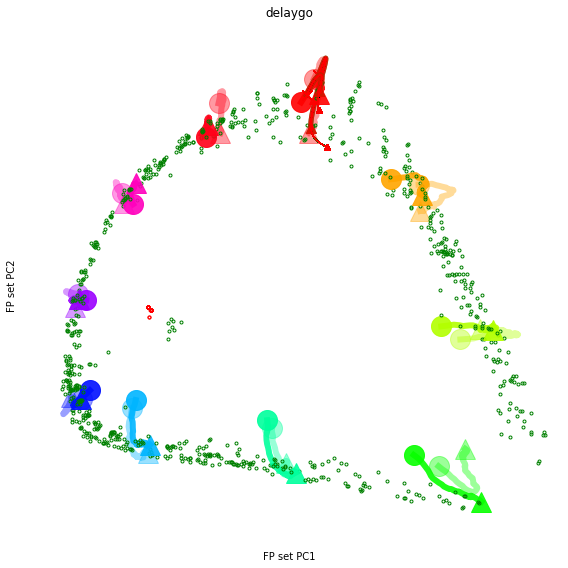

In [90]:
########## X TASK ###########

fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['dmsgo','delaygo']
epoch_set = ['delay1','delay1']
step_file = 'interp_tasks'
linestyle = ['-','-']
axs = 'pca_fp'
q_str = 'tol_q_e_3.0'

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['navy','gold']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use,_,_ = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rand_step_coef = 0
al = .3

for ri in range(2):
    
    rule = rule_set[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    ax = plt.subplot(111)
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
           linestyle = linestyle[ri], alpha = (ri/2)+.4, markersize = 20)
    
    filename,_ = get_filename(trial,epoch,trial_num[ri])
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    fp_struct = np.load(f)
    fp_inds = fp_struct['qstar']<.0001
    sorted_fps = fp_struct['xstar'][fp_inds,:]
    J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
    eig_decomps = comp_eig_decomp(J_xstar)
    fp_inds = range(len(eig_decomps))
    
    plot_FP_jitter(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
               rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
                   n_jit = 0,c_master = 'g')
    
    f = os.path.join(m,'lesion_fps_hierarchical_ward_max_d3/tf_fixed_pts_lesion_13/',rule,'delay1_0.0.npz')
    fp_struct = np.load(f)
    fp_inds = fp_struct['qstar']<.0001
    sorted_fps = fp_struct['xstar'][fp_inds,:]
#     J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
#     eig_decomps = comp_eig_decomp(J_xstar)
    fp_inds = range(len(sorted_fps))
    
    plot_FP_jitter(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
           rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
               n_jit = 0,c_master = 'r')

tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
# plt.title(tit,fontsize = 18)
# plt.xlabel(axes_label1,fontsize = 18)
# plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlim((-5,13))
plt.ylim((-8,10))

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
    
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [ ]:
########## X EPOCH ###########

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [0,0]
trial_num = [0,0]
trial_set = range(0,80,10)
rule_set = ['delaygo',]
epoch_set = ['stim1','delay1']
step_file = 'interp_epochs'
linestyle = ['-','--']
axs ='pca'

ri = 0
rule = rule_set[ri]
epoch_axs = 0

f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch_set[epoch_axs]+'_'+str(t_set[epoch_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch_set[epoch_axs],axs =axs, clust = 'False')
epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule_set[0])
epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule_set[0])
axes_label1 = axs + ' 1'
axes_label2 = axs + ' 2'

# use_yinds = [4,5]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['navy','gold']

for ei in range(len(epoch_set)):
    ax = plt.subplot(111)
    
    epoch = epoch_set[ei]
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    stable_fp = np.log10(qvals)<-6
    plt.plot(fp_project[stable_fp==1,0],fp_project[stable_fp==1,1],'o',c = cmap_discrete[ei],
             markersize = 10, alpha = 1, linewidth = 2)
    plt.plot(fp_project[stable_fp==0,0],fp_project[stable_fp==0,1],'o',c = cmap_discrete[ei],
             markersize = 10, markerfacecolor = 'none', alpha = 1, linewidth = 2)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
#     plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 2, linestyle = linestyle[ei])
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[1])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
           linestyle = linestyle[ri], alpha = .1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[ei],epoch,sorted_fps,range(len(sorted_fps)),qvals,
              rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
              n_jit = 1,unstable_qlim = -10,c = cmap_discrete[ei])

    for step_i in range(20):
        f = rule_set[0]+'_'+epoch_set[0]+'_'+epoch_set[1]+'_'+str(t_set[ri])+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,rule_set[0],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']
#         print(len(step_fps))

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = 'X EPOCH ' + epoch_set[0]+' vs. '+epoch_set[1]
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [46]:
os.path.join(figpath,step_file,figname+'.pdf')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_epochs/pca 1_pca 2_delaygo_delay1_0_X EPOCH stim1 vs. delay1.pdf'